In [1]:
import networkx as nx
from itertools import combinations
import matplotlib.pylab as plt # Para graficar networkx y demases
import matplotlib.cm as cm # para mapas de colores

Hacemos una función que encuentra las comunidades con el método de percolación de cliques para distintos k.

In [2]:
def get_percolated_cliques(G, k):
    if k < 2:
        raise nx.NetworkXError("k=%d, k must be greater than 1."%k)
        
    cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)

    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    
    for c1, c2 in combinations(cliques, 2):
        if len(c1.intersection(c2)) >= (k - 1):
            perc_graph.add_edge(c1, c2)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

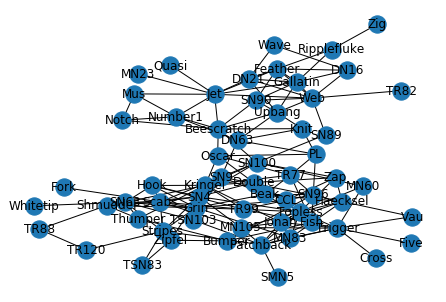

In [3]:
Red_delfines = nx.read_gml('./data/dolphins.gml')
posiciones = nx.kamada_kawai_layout(Red_delfines)
nx.draw(Red_delfines, pos = posiciones, with_labels = True)

# Chequeemos que esto que hice tenga sentido:
* Recorrer con varios k y buscar óptimo (con qué heurística?)
* Los más sociables son los que están en dos comunidades?

Queremos recorrer varios valores de k para los cliques

In [4]:
comunidades_cliques = {}
for k in range(2, max(dict(Red_delfines.degree()).values())):
    comunidades_cliques[k] = {}
    for i, community in enumerate(list(get_percolated_cliques(Red_delfines, k))):
        for dolphin in community:
            comunidades_cliques[k].setdefault(dolphin, [])
            comunidades_cliques[k][dolphin].append(i)   

In [5]:
#Borro los vacios
empty_keys = [k for k,v in comunidades_cliques.items() if not v]
for k in empty_keys:
    del comunidades_cliques[k]

In [6]:
max_comunidades = 0
max_comunidades_por_delfin = 0

for k in comunidades_cliques.keys():
    #si un nodo esta en mas de una comunidad tiene una lista de comunidades
    comunidades_por_delfin = len(max(comunidades_cliques[3].values(), key = len))
    if comunidades_por_delfin > max_comunidades_por_delfin:
        max_comunidades_por_delfin = comunidades_por_delfin
    
    cantidad_de_comunidades = max([max(comu) for comu in zip(*comunidades_cliques[k].values())]) 
    if cantidad_de_comunidades > max_comunidades:
        max_comunidades = cantidad_de_comunidades
        
        
print(f'La partición con más comunidades tiene {max_comunidades} y un delfín está como mucho en {max_comunidades_por_delfin} comunidades a la vez')

La partición con más comunidades tiene 3 y un delfín está como mucho en 2 comunidades a la vez


In [13]:
def graficar_cliques(particion, ax = None, posiciones = nx.kamada_kawai_layout(Red_delfines), colores = cm.get_cmap('viridis', 3)):
    #Vemos que delfines no tienen comunidad o estan en dos
    nodos_sin_comunidad = set(Red_delfines.nodes()).difference(set(particion.keys()))
    nodos_en_dos = []
    for delfin, comunidad in particion.items():
        if len(comunidad) == 2:
            nodos_en_dos.append(delfin)
    
    #Vamos con colores segun particion
    colores_list = []
    colores_segunda_comunidad = []
    for nodo in particion.keys():
        if nodo in nodos_en_dos:
            colores_list.append(particion[nodo][1]) #me quedo con el segundo color
            colores_segunda_comunidad.append(particion[nodo][0]) #nos quedamos con el otro
        else: 
            colores_list.append(particion[nodo][0]) 
    
    #Graficamos los nodos
    
    #Los que tienen comunidad
    nx.draw_networkx_nodes(Red_delfines, posiciones, particion, node_size=300,
                           node_color= colores_list, with_labels = False, ax=ax)
    #Los que estan en dos (asi superponemos colores)
    nx.draw_networkx_nodes(Red_delfines, posiciones, nodos_en_dos, node_size = 100, node_color = colores_segunda_comunidad, alpha = 0.9, ax=ax)
    
    #Nodos sin comunidad en negro
    nx.draw_networkx_nodes(Red_delfines, posiciones, nodos_sin_comunidad, node_size = 50, node_color = 'black', alpha = 0.5, ax=ax)

    
    #Graficamos enlaces
    nx.draw_networkx_edges(Red_delfines,pos = posiciones, alpha=0.5, ax=ax)
    
    #Legend de nodos sin comunidad
    ax.scatter([],[], c = 'black', marker = 'o', alpha = 0.7, label= 'Nodos sin comunidad') 
    

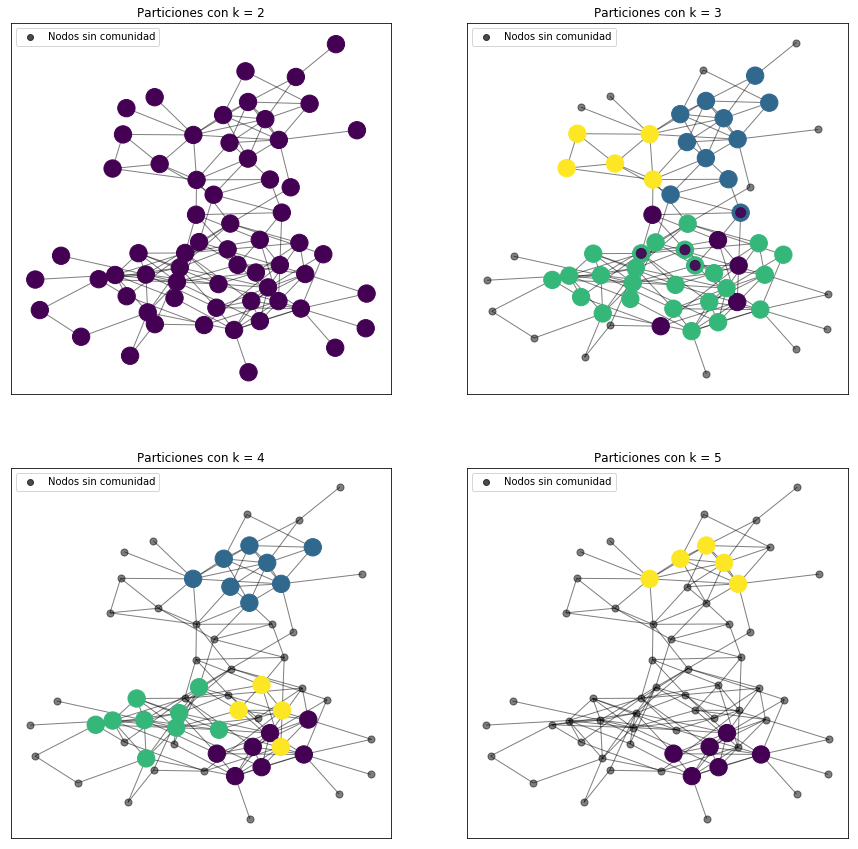

In [14]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,k in enumerate(comunidades_cliques):
    graficar_cliques(comunidades_cliques[k], ax = axs[i])
    axs[i].set_title(f'Particiones con k = {k}')
    axs[i].legend()


# Aca podriamos poner algo mas cheto del porque 

Nos quedamos con la partición de k = 3 que agrupa la mayor cantidad de nodos en comunidades. Con k = 2 es un parámetro muy permisivo y todos los delfines quedan en la misma. Podemos encontrar una explicación debido al grado medio de la red. 

In [170]:
grado_medio = 2 * Red_delfines.number_of_edges() / Red_delfines.number_of_nodes()
print(f'El grado medio de la red de delfines {round(grado_medio, 2)}')

El grado medio de la red de delfines 5.13


Para k = 3 hay individuos que no están en comunidades o que están en más de una comunidad, estos son los que tienen dos colores en el gráfico. 

In [173]:
nodos_sin_comunidad = set(Red_delfines.nodes()).difference(set(comunidades_cliques[3].keys()))
porcentaje_sin_comunidad = len(nodos_sin_comunidad) / Red_delfines.number_of_nodes() *100
print(f'Los delfines que quedan sin comunidad son {nodos_sin_comunidad}, son un {round(porcentaje_sin_comunidad, 2)}% del total.')

Los delfines que quedan sin comunidad son {'TR88', 'SN89', 'Zig', 'MN23', 'TSN83', 'SMN5', 'Vau', 'Quasi', 'Five', 'Whitetip', 'Cross', 'TR82', 'Fork', 'Zipfel', 'TR120', 'Wave'}, son un 25.81% del total.


In [176]:
nodos_en_dos = []
for delfin, comunidad in comunidades_cliques[3].items():
    if len(comunidad) == 2:
        nodos_en_dos.append(delfin)
        
porcentaje_dos_comunidades = len(nodos_en_dos) / Red_delfines.number_of_nodes() *100      

print(f'Los delfines que quedan en dos comunidades son {nodos_en_dos}, son un {round(porcentaje_dos_comunidades, 2)}% del total.')

Los delfines que quedan en dos comunidades son ['Beak', 'Double', 'Kringel', 'Beescratch', 'Jet', 'PL'], son un 9.68% del total.


A esos delfines los consideraremos los más sociables.

# Aca podriamos poner caracteristicas de los delfines esos
* Grado
* e t c, las escucho

In [179]:
Red_delfines.degree(nodos_en_dos)

DegreeView({'Beak': 6, 'Double': 6, 'Kringel': 9, 'Beescratch': 8, 'Jet': 9, 'PL': 5})